In [204]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

In [205]:
np.random.seed(42)

NAME = 'assignment3'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Question 1: Complex calcium oscillations

In [206]:
# Declare parameters
#---------------------------------------
# Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

# Kinetics parameters

k_pump = 20 #s^-1
k_ch = 3900 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

# Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2 
Ca_m_0 = 1 

In [207]:
def hill_eq(x, K, n):
    """
    Returns the Hill equation
    - x := total ligand concentration
    - K := half-saturation constant
    - n := Hill coefficient
    """
    return x**n / (K**n + x**n)

def Ca_system(y, t, k_pump=k_pump, k_ch=k_ch, k_leak=k_leak, k_in=k_in, k_out=k_out, k_m=k_m, k_plus=k_plus, k_minus=k_minus, K1=K1, K2=K2, K3=K3, Ca_tot=Ca_tot, Pr_tot=Pr_tot, beta_ER=beta_ER, beta_m=beta_m, rho_ER=rho_ER, rho_m=rho_m):
    """
    Multi-compartmental model of calcium dynamics
    
    y := [Ca_cyt, Ca_ER, Ca_m]
    t := time
    
    Returns:
    - dCa_cyt/dt
    - dCa_ER/dt
    - dCa_m/dt
    """
    Ca_cyt, Ca_ER, Ca_m = y
    J_pump = k_pump*Ca_cyt
    J_ch = k_ch*hill_eq(Ca_cyt, K1, 2)*(Ca_ER - Ca_cyt)
    J_leak = k_leak*(Ca_ER - Ca_cyt)
    J_in = k_in*hill_eq(Ca_cyt, K2, 8)
    J_out = Ca_m*(k_out*hill_eq(Ca_cyt, K3, 2) + k_m)
    CaPr = Ca_tot - Ca_cyt -(rho_ER/beta_ER)*Ca_ER - (rho_m/beta_m)*Ca_m
    Pr = Pr_tot - CaPr

    dCa_cyt = J_ch + J_leak - J_pump + J_out - J_in + k_minus*CaPr - k_plus*Ca_cyt*Pr
    dCa_ER = (beta_ER/rho_ER)*(J_pump - J_ch - J_leak)
    dCa_m = (beta_m/rho_m)*(J_in - J_out)
    
    return [dCa_cyt, dCa_ER, dCa_m]

def solve_system(t_span, y0, t_eval, system=Ca_system, method='LSODA', rtol=1e-10, atol=1e-10, **kwargs):
    """
    Solves the system of ODEs
    """
    final_system = lambda y, t: system(t, y, **kwargs)
    sol = solve_ivp(final_system, t_span, y0, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
    return sol.t, sol.y

In [208]:
t_span = (0, 300)
t_eval = np.linspace(*t_span, 50_000)
y0 = [Ca_cyt_0, Ca_ER_0, Ca_m_0]
k_chs = [3900, 4000, 2830]

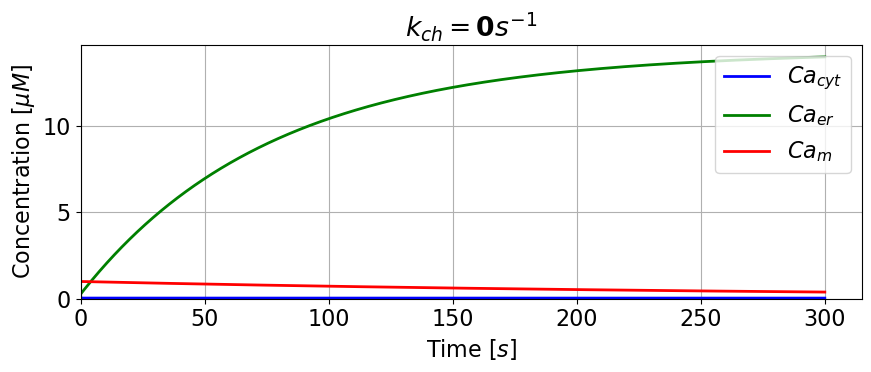

In [209]:
plt.rcParams.update({"font.size" : 16})
plt.figure(figsize=(9,4), layout='tight')

t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=0)
ca_cyt, ca_er, ca_m = y[0], y[1], y[2]

plt.plot(t, ca_cyt, label=r"$Ca_{cyt}$", c="blue", lw=2)
plt.plot(t, ca_er, label=r"$Ca_{er}$", c="green", lw=2)
plt.plot(t, ca_m, label=r"$Ca_{m}$", c="red", lw=2)
plt.xlabel(r"Time $[s]$")
plt.ylabel(r"Concentration $[\mu M]$")
plt.title(r"$k_{ch} = $" + f"{0}" + r"$s^{-1}$", fontweight='bold')
plt.xlim(0,)
plt.ylim(0,)
plt.legend(loc="upper right")
plt.grid()
plt.savefig(f"{MEDIA_PATH}/calcium_oscillations_k_ch_0.png", dpi=300, bbox_inches='tight')
plt.show()

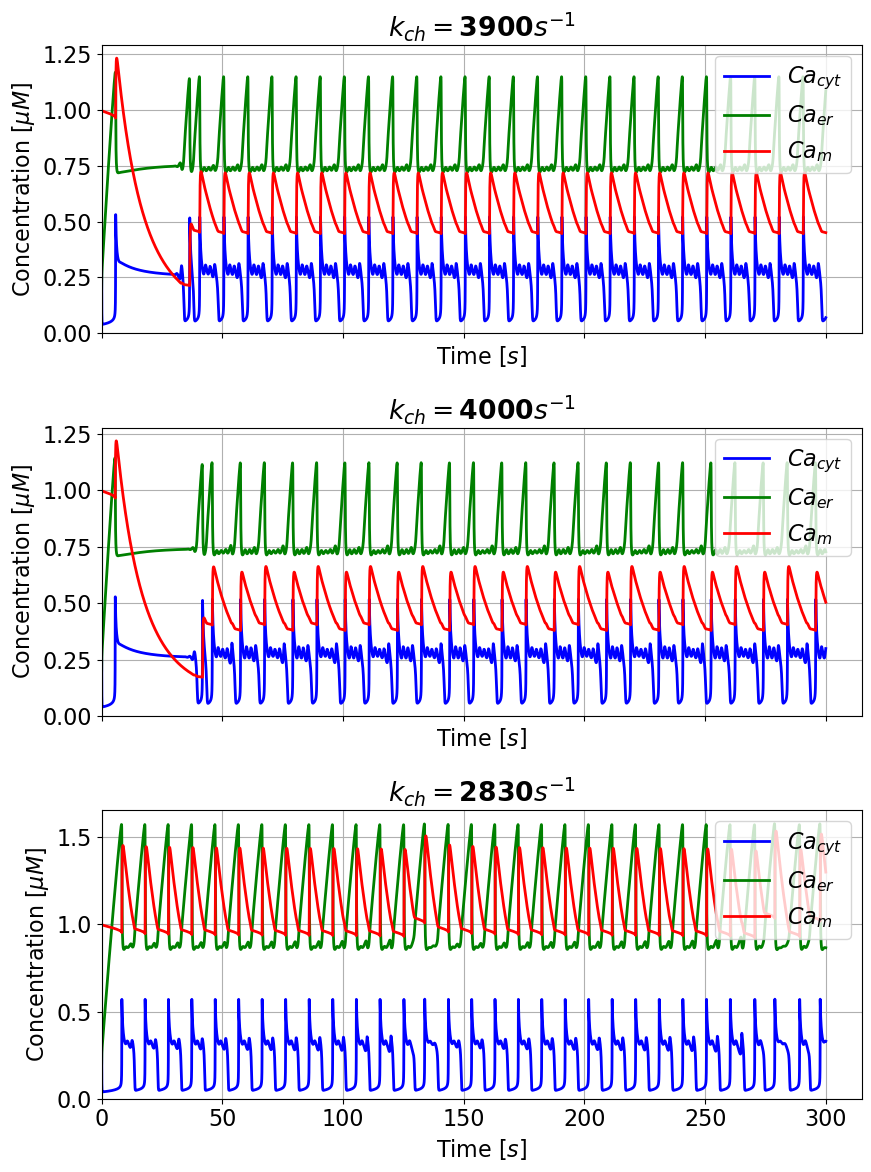

In [210]:
plt.rcParams.update({"font.size" : 16})

fig, axes = plt.subplots(3,1,figsize=(9,12), sharex=True, layout='tight')

for (ax, k_ch) in zip(axes.flatten(), k_chs):
    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    ca_cyt, ca_er, ca_m = y[0], y[1], y[2]

    ax.plot(t, ca_cyt, label=r"$Ca_{cyt}$", c="blue", lw=2)
    ax.plot(t, ca_er, label=r"$Ca_{er}$", c="green", lw=2)
    ax.plot(t, ca_m, label=r"$Ca_{m}$", c="red", lw=2)

    ax.set_xlabel(r"Time $[s]$")
    ax.set_ylabel(r"Concentration $[\mu M]$")
    ax.set_title(r"$k_{ch} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')
    ax.set_xlim(0,)
    ax.set_ylim(0,)
    ax.legend(loc="upper right")
    ax.grid()

fig.savefig(f"{MEDIA_PATH}/calcium_oscillations.png", dpi=300, bbox_inches='tight')
plt.show()

### f) & g)

**Description for $k_{ch} = 3900 s^{-1}$**

At the initial stage of the system (up untill $t \approx 40$), the model seems to stabilize and adjust the concentrations to the provided model parameters. First, $CaPr$ complexes dissociate in the cytosol and most of the cytosolic calcium is pumped into the ER, creating a spike. This calcium is quickly released through the ER membrane channels, causing a quick subsequent spikes in both the cytosolic and mitochondrial calcium. When sequestration in mitochondria ends and the concentration reaches a peak, the calcium begins to slowly leak up untill $t \approx 40$. Some of the cytosolic calcium is bound into the proteins, causing a rapid drop. After the release, ER calcium almost stabilizes and there are no major changes untill the oscillation period, which begins at $t \approx 40$.

The oscillations in calcium concentrations can be divided into three phases. The ER release phase, when the ER calcium quickly drops, and causes a rapid subsequent spike in cytosolic and mitochondrial calcium. The bursting phase, when the mitochondrial calcium steadily decreases at a much slower rate, than it increased during ER release phase. Finally, the silent phase, when the $CaPr$ complexes dissociate and resulting free calcium molecules are pumped into the ER. For simplification, these phases will be referred to as Phase I, Phase II and Phase III, respectively.

In Phase I, ER calcium rapidly drops, while the cytosolic and mitochondrial calcium rapidly concentration rapidly increases. Calcium release from the ER is the dominating process in Phase I. Efflux from the ER, most of which occurs through the membrane channels, quickly increases the concentration in the surrounding cytosol. As described in the theoretical analysis of the system, a large part of this released cytosolic calcium is then rapdily sequestered into the mitochondria. This results in the spike in mitochondrial calcium.

In Phase II, mitochondrial calcium is steadily (but not linearly) decreasing. Slow mitochondrial leakage is the dominating process of Phase II. This phase is much longer than Phase I, which goes in line with the fact that calcium uptake is much faster than its release in the mitochondria. Calcium ions are transferred from mitochondria to cytosolic proteins, allowing for binding and creation of $CaPr$ complexes. This is a long term process, during which occurs another, faster, process - the exchange of calcium between the ER and cytosolic proteins. The combined effect of this exchange and binding are small calcium spikes and bursting oscillations visible on the plot in cytosolic and ER concentrations.

Finally, in phase III, the silent phase, is governed by the dissociation of accumulated $CaPr$ complexes in the cytosol. Concentration of this complexes rapidly drops (not shown on the plot) resulting in many free calcium molecules and unbounded protein sites. The dissociation process is again accompanied by a fast absorption of calcium from the cytosol into the ER, causing a quick spike and drop in cytosolic and ER calcium, respectively.

### h)

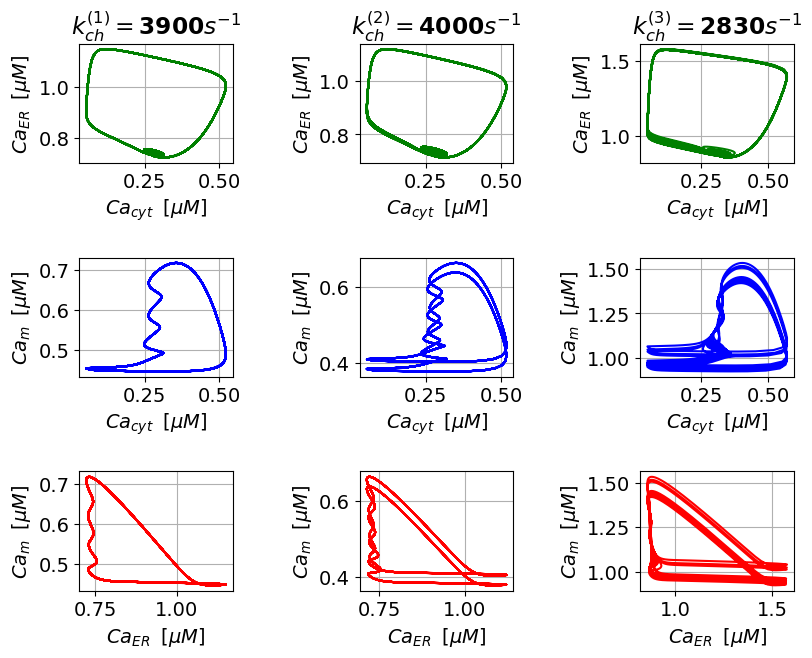

In [211]:
# Phase plots
plt.rcParams.update({"font.size" : 14})
fig, axes = plt.subplots(3,3,figsize=(9,7))
fig.tight_layout(pad=3.0)

# Index for cutoff of initial phase, where oscillations begin
osc_start = int(0.2 * t.shape[0])

for (i, k_ch) in enumerate(k_chs):
    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    ca_cyt, ca_er, ca_m = y[0], y[1], y[2]

    # Cut the results to only include the oscillations
    t_osc = t[osc_start:]
    ca_cyt_osc, ca_er_osc, ca_m_osc = ca_cyt[osc_start:], ca_er[osc_start:], ca_m[osc_start:]

    # Plotting
    axes[0,i].plot(ca_cyt_osc, ca_er_osc, c="green")
    axes[0,i].set_xlabel(r"$Ca_{cyt} \; \; [\mu M]$")
    axes[0,i].set_ylabel(r"$Ca_{ER} \; \; [\mu M]$")
    axes[0,i].grid()

    axes[1,i].plot(ca_cyt_osc, ca_m_osc, c="blue")
    axes[1,i].set_xlabel(r"$Ca_{cyt} \; \; [\mu M]$")
    axes[1,i].set_ylabel(r"$Ca_{m} \; \; [\mu M]$")
    axes[1,i].grid()

    axes[2,i].plot(ca_er_osc, ca_m_osc, c="red")
    axes[2,i].set_xlabel(r"$Ca_{ER} \; \; [\mu M]$")
    axes[2,i].set_ylabel(r"$Ca_{m} \; \; [\mu M]$")
    axes[2,i].grid()

    axes[0,i].set_title(r"$k_{ch}^{("+str(i+1)+r")} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')

fig.savefig(f"{MEDIA_PATH}/2d_phase_plots.png", dpi=300, bbox_inches='tight')
plt.show()

### i)

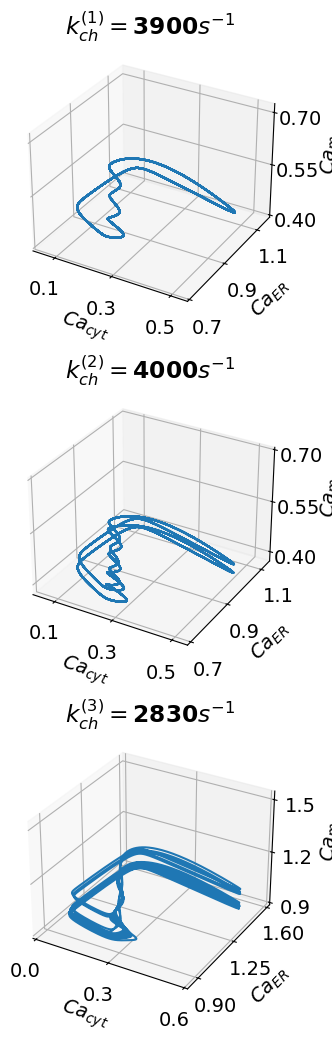

In [212]:
plt.rcParams.update({"font.size" : 14})
fig = plt.figure(figsize=(15, 12.5))

for (i, k_ch) in enumerate(k_chs):
    ax = fig.add_subplot(3,1,i+1,projection="3d")

    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    ca_cyt, ca_er, ca_m = y[0], y[1], y[2]

    # Cut the results to only include the oscillations
    t_osc = t[osc_start:]
    ca_cyt_osc, ca_er_osc, ca_m_osc = ca_cyt[osc_start:], ca_er[osc_start:], ca_m[osc_start:]

    # Plotting
    cmap = plt.get_cmap()
    ax.plot(ca_cyt_osc, ca_er_osc, zs=ca_m_osc, lw=1.5)

    ax.set_xlabel(r"$Ca_{cyt}$", labelpad=5)
    ax.set_ylabel(r"$Ca_{ER}$", labelpad=5)
    ax.set_zlabel(r"$Ca_{m}$", labelpad=5)

    ax.set_xticks(np.linspace(np.round(np.min(ca_cyt_osc), 1), np.round(np.max(ca_cyt_osc), 1), 3))
    ax.set_yticks(np.linspace(np.round(np.min(ca_er_osc), 1), np.round(np.max(ca_er_osc), 1), 3))
    ax.set_zticks(np.linspace(np.round(np.min(ca_m_osc), 1), np.round(np.max(ca_m_osc), 1), 3))

    ax.set_title(r"$k_{ch}^{("+str(i+1)+r")} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')

plt.subplots_adjust(hspace=0.25)
fig.savefig(f"{MEDIA_PATH}/3d_phase_plots.png", dpi=300, bbox_inches='tight')
plt.show()

## l)

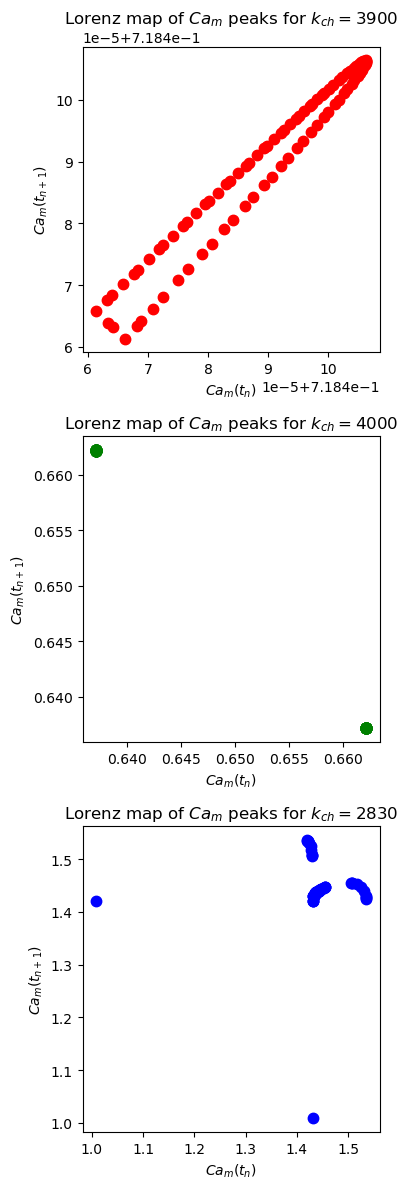

In [213]:
plt.rcParams.update({"font.size" : 10})
colors = ['red', 'green', 'blue']

def get_peaks_of_Ca_m(t, Ca_m):
    peaks, _ = find_peaks(Ca_m, height=0.05)
    return t[peaks], Ca_m[peaks]

def lorenz_map_subplot(ax, Ca_m_peaks, k_ch, color):
    Ca_m_peaks = Ca_m_peaks[1]
    ax.plot(Ca_m_peaks[:-1], Ca_m_peaks[1:], 'o', markersize=7.5, color=color)
    ax.set_xlabel('$Ca_m(t_{n})$')
    ax.set_ylabel('$Ca_m(t_{n+1})$')
    ax.set_title(f'Lorenz map of $Ca_m$ peaks for $k_{{ch}} = {k_ch}$')

k_chs = [3900, 4000, 2830]
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 30_000)
t_range = (100, 1000)
mask = (t_eval >= t_range[0]) & (t_eval <= t_range[1])

fig, axs = plt.subplots(len(k_chs), 1, figsize=(4, 4*len(k_chs)))

for ax, k_ch, color in zip(axs, k_chs, colors):
    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    Ca_m = y[2]
    Ca_m_peaks = get_peaks_of_Ca_m(t[mask], Ca_m[mask])
    lorenz_map_subplot(ax, Ca_m_peaks, k_ch=k_ch, color=color)

fig.tight_layout()
fig.savefig(f"{MEDIA_PATH}/lorenz_map.png", dpi=300, bbox_inches='tight')
plt.show()

# Question 2: Schnakenberg model

### a) & b)

Nature is full of examples of formation of complex and unique patterns, with researchers dedicating entire books to this particular topic. Notable examples involve plants (Lindenmayer & Prusinkiewicz, 1990) sea shells (Meinhardt, 1995) or sponges and corals (Kaandorp & Kübler, 2001). The fundamental question in computational and fundamental biology is how this vast range of pattern and structure is formed from an almost uniformly homogeneous fertilized egg. In 1952, Alan Turing hypothesized that these patterns can form due to the pre-formed configuration and intereaction of biochemicals called morphogens. The system proposed by Turing (**ADD REF**) conditioned the time-dependent change of a vector of morphogens $u$ on the diffusion term (the Laplace term) and the reaction interchemical kinetics.

$$
\begin{equation}
    \frac{\delta u}{\delta t} = \mathbf{D} \nabla^{2} \mathbf{u} + \mathbf{f(u)}
\end{equation}
$$

The Schnakenberg model (**ADD REF**) is a specific realisation of the system proposed by Turing, with two morphogens interacting with each other. The $D_u$ and $D_v$ are their respective diffusion constants or the rates at which chemicals disperse in space. Parameters $c_1, c_{-1}, c_2, c_3$ represent the reaction rates occuring in the system. Schnakenberg developed his kinematic reaction model in search for a minimal chemically sensible exhitbiting a limit-cycle behaviour i.e. temporal periodic solutions ("Pattern formation analysis in Schnakenberg model", Beentjes 2014). It is based on reactions between four general chemicals $X, A, B, Y$ and can be derived by making the assumption that A, B are constant. In the corresponding reaction kinetics model (**ADD REF**), $X$ engages in a reversible conversion to $A$, $B$ converts irreversibly to $Y$ and a pair of $X$ molecules bind with $Y$ to create an $X$ triplet. After writing down four corresponding time derivatives for chemical concentration the law of mass action and assuming constant $A$ and $B$: $\frac{\delta [A]}{\delta t} = \frac{\delta [B]}{\delta t} = 0$ we arrive at the Schnakenberg model (**ADD REF**).

$$
\begin{equation}
    X \xrightleftharpoons[k_1]{k_{-1}} A \hspace{1cm} B \xrightharpoonup[]{k_2} Y \hspace{1cm} 2X + Y \xrightharpoonup[]{k_3} 3X 
\end{equation}
$$

$$
\begin{equation}
\begin{split}
    \frac{\delta u}{\delta t} &= D_u \nabla^{2} \mathbf{u} + c_1 - c_{-1} u + c_3 u^2 v \\
    \frac{\delta v}{\delta t} &= D_v \nabla^{2} \mathbf{v} + c_2 - c_3 u^2 v
\end{split}
\end{equation}
$$

### c) & d)

In [214]:
def laplacian_1d(z, dx):
    """
    Approximates the Laplacian using finite difference method and periodic boundary conditions.
    - z  := vector to take the Laplacian for
    - dx := lattice step
    """
    return (np.roll(z, 1) + np.roll(z, -1) - 2*z) / (dx**2)


def run_schnakenberg_model_1d(u0, v0, dt, nt, params):
    """
    Runs the Schnakenberg model.
    - u0 := initial state of chemical u
    - v0 := initial state of chemical v
    - dt := time step
    - nt := no. of simulation steps
    """

    # Rename the chemical vectors for clarity
    u = u0
    v = v0
    
    # Checking validity of input parameters
    acceptable_names = [ "cp1", "cm1", "c2", "c3", "Du", "Dv", "L", "N"]
    
    for param in params.keys():
        assert param in acceptable_names

    # Initializing model parameters as given by input or to default values
    cp1 = params["cp1"] if "cp1" in params else 0.1
    cm1 = params["cm1"] if "cm1" in params else 1.0
    c2 = params["c2"] if "c2" in params else 0.9
    c3 = params["c3"] if "c3" in params else 1
    Du = params["Du"] if "Du" in params else 0.0004
    Dv = params["Dv"] if "Dv" in params else 0.016
    L = params["L"] if "L" in params else 1
    N = params["N"] if "N" in params else 100

    # Validate provided N is consistent with u0 and v0
    assert u0.shape == (N, )
    assert v0.shape == (N, )

    # Calculate lattice step
    dx = (L / N)

    # Run the simulation
    for i in range(nt):
        unew = u + dt * (Du * laplacian_1d(u, dx) + cp1 - cm1 * u + c3*(u**2 * v))
        vnew = v + dt * (Dv * laplacian_1d(v, dx) + c2 - c3*(u**2 * v))

        u = unew
        v = vnew

    return u, v

In [215]:
# Model parameters, note that other parameters are assigned by default inside the method itself
N = 100
dt = 0.001
tmax = 35
nt_tot = int(tmax / dt)

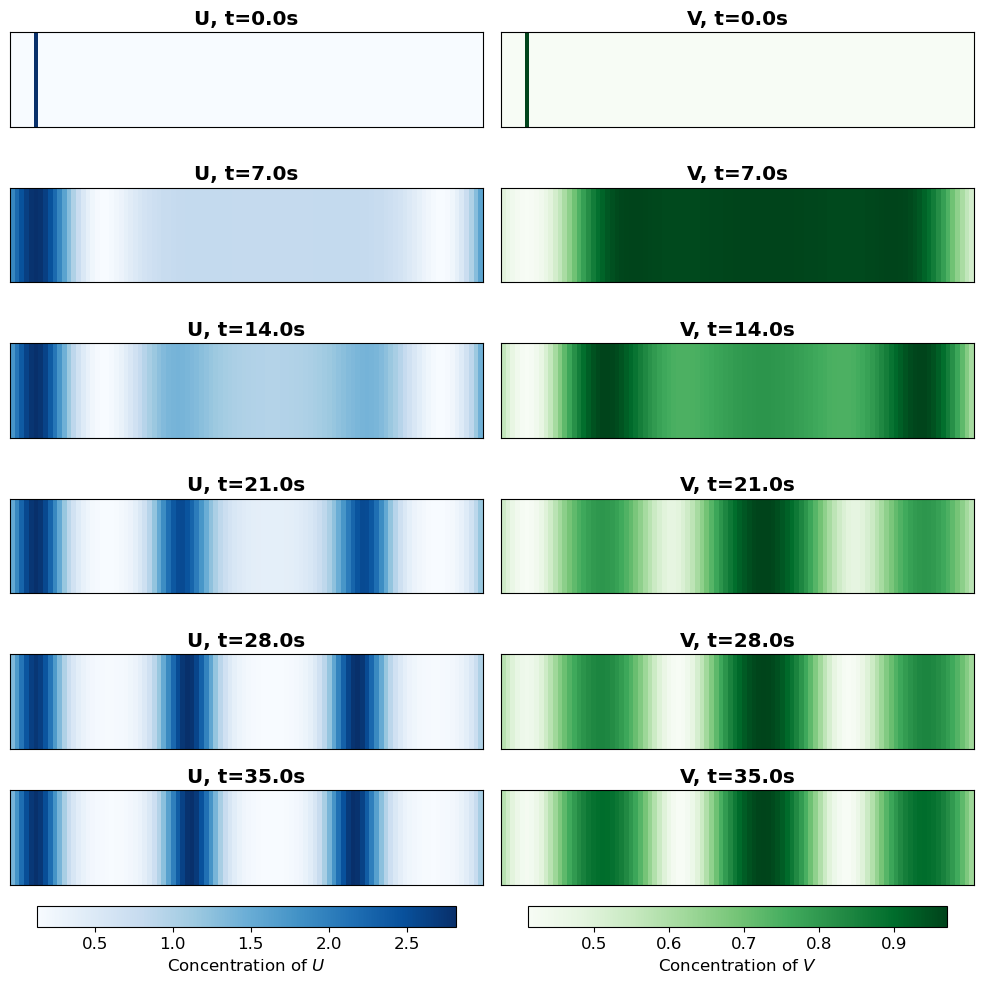

In [216]:
plt.rcParams.update({"font.size" : 14})

# Initial conditions
u0 = np.zeros(N)
v0 = np.zeros(N)

u0[5] = 1
v0[5] = 3

# Plots at five evenly spaced steps
nt = int(nt_tot / 5)
u, v = u0, v0

fig, axes = plt.subplots(6,2,figsize=(10,10), layout='tight')
plt.rcParams.update({"font.size" : 12})

for i in range(6):
    # Plotting
    u_im = axes[i,0].imshow(u.reshape(1,N), aspect=20, cmap='Blues')
    v_im = axes[i,1].imshow(v.reshape(1,N), aspect=20, cmap='Greens')

    axes[i,0].set_xticks([])
    axes[i,1].set_xticks([])

    axes[i,0].set_yticks([])
    axes[i,1].set_yticks([])

    axes[i,0].set_title(f"U, t={i*nt*dt}s", fontweight='bold')
    axes[i,1].set_title(f"V, t={i*nt*dt}s", fontweight='bold')

    u0, v0 = u, v

    # Simulation
    u, v = run_schnakenberg_model_1d(u0, v0, dt, nt, {})

fig.colorbar(u_im, ax=axes[i,0], orientation='horizontal', label='Concentration of $U$')
fig.colorbar(v_im, ax=axes[i,1], orientation='horizontal', label='Concentration of $V$')

fig.savefig(f"{MEDIA_PATH}/schnakenberg_1d.png", dpi=300, bbox_inches='tight')
plt.show()

### f) & g)

In [217]:
def laplacian_2d(z, dx):
    """
    Approximates the 2D Laplacian using finite difference method and periodic boundary conditions.
    - z  := vector to take the Laplacian for
    - dx := lattice step
    """
    return (np.roll(z, 1, axis=0) + np.roll(z, -1, axis=0) +
            np.roll(z, 1, axis=1) + np.roll(z, -1, axis=1) -
            4*z) / (dx**2)


def run_schnakenberg_model_1d(u0, v0, dt, nt, params):
    """
    Runs the Schnakenberg model.
    - u0 := initial state of chemical u
    - v0 := initial state of chemical v
    - dt := time step
    - nt := no. of simulation steps
    """

    # Rename the chemical vectors for clarity
    u = u0
    v = v0
    
    # Checking validity of input parameters
    acceptable_names = [ "cp1", "cm1", "c2", "c3", "Du", "Dv", "L", "N"]
    
    for param in params.keys():
        assert param in acceptable_names

    # Initializing model parameters as given by input or to default values
    cp1 = params["cp1"] if "cp1" in params else 0.1
    cm1 = params["cm1"] if "cm1" in params else 1.0
    c2 = params["c2"] if "c2" in params else 0.9
    c3 = params["c3"] if "c3" in params else 1
    Du = params["Du"] if "Du" in params else 0.0004
    Dv = params["Dv"] if "Dv" in params else 0.016
    L = params["L"] if "L" in params else 1
    N = params["N"] if "N" in params else 100

    # Validate provided N is consistent with u0 and v0
    assert u0.shape == (N, N)
    assert v0.shape == (N, N)

    # Calculate lattice step
    dx = (L / N)

    # Run the simulation
    for i in range(nt):
        unew = u + dt * (Du * laplacian_2d(u, dx) + cp1 - cm1 * u + c3*(u**2 * v))
        vnew = v + dt * (Dv * laplacian_2d(v, dx) + c2 - c3*(u**2 * v))

        u = unew
        v = vnew

    return u, v

In [218]:
# Model parameters, note that other parameters are assigned by default inside the method itself
N = 100
dt = 0.001
tmax = 35
nt_tot = int(tmax / dt)

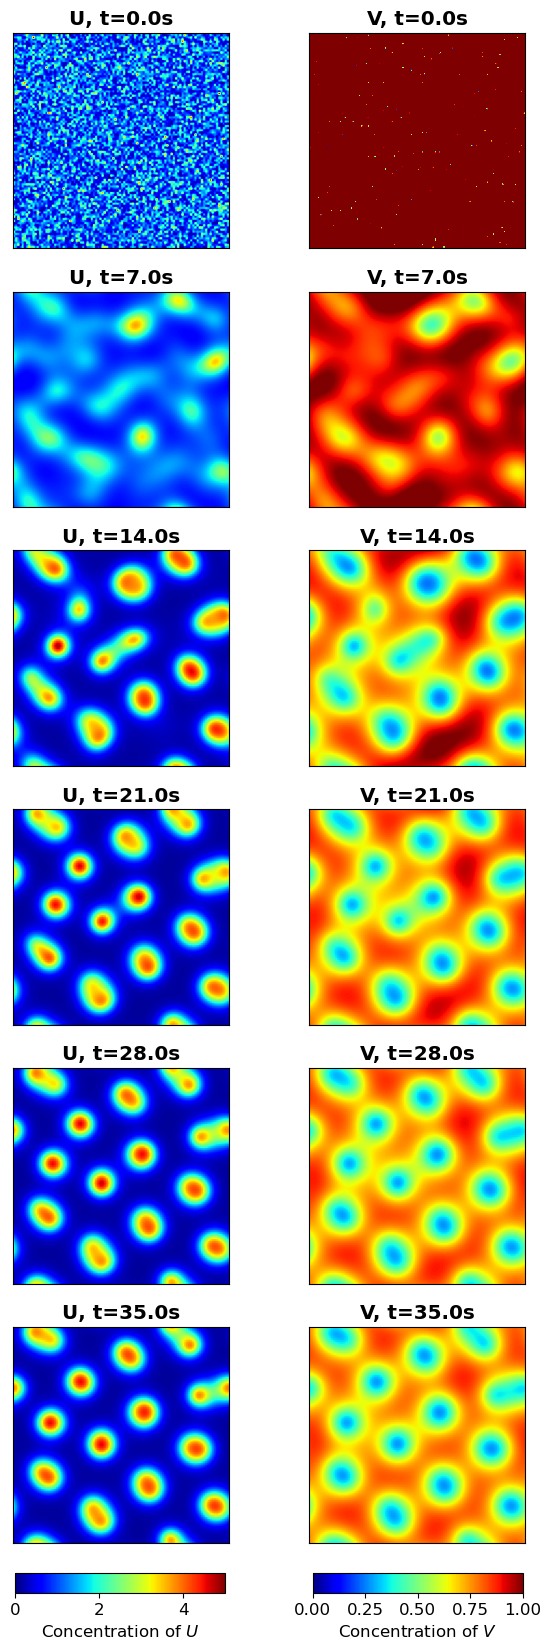

In [219]:
# Initial conditions
u0 = np.abs(np.random.normal(loc=1, size=(N, N)))
v0 = np.abs(np.random.normal(loc=3, size=(N, N)))

# Plots at five evenly spaced steps
nt = int(nt_tot / 5)
u, v = u0, v0

fig, axes = plt.subplots(6,2,figsize=(7,20))
plt.rcParams.update({"font.size" : 12})

for i in range(6):
    # Plotting
    im_u = axes[i,0].imshow(u, cmap='jet', vmin=0, vmax=5)
    im_v = axes[i,1].imshow(v, cmap='jet', vmin=0, vmax=1)

    axes[i,0].set_xticks([])
    axes[i,1].set_xticks([])

    axes[i,0].set_yticks([])
    axes[i,1].set_yticks([])

    axes[i,0].set_title(f"U, t={i*nt*dt}s", fontweight='bold')
    axes[i,1].set_title(f"V, t={i*nt*dt}s", fontweight='bold')

    u0, v0 = u, v

    # Simulation
    u, v = run_schnakenberg_model_1d(u0, v0, dt, nt, { "N": N })

plt.subplots_adjust(bottom=0.125)
cbar_ax_u = fig.add_axes([0.15, 0.1, 0.3, 0.01])
cbar_ax_v = fig.add_axes([0.575, 0.1, 0.3, 0.01])
fig.colorbar(im_u, cax=cbar_ax_u, orientation='horizontal', label='Concentration of $U$')
fig.colorbar(im_v, cax=cbar_ax_v, orientation='horizontal', label='Concentration of $V$')

plt.savefig(f"{MEDIA_PATH}/schnakenberg_2d.png", dpi=300, bbox_inches='tight')
plt.show()